In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Set working directory (dataset directory)
data_dir = '/content/drive/MyDrive/Fed_auth'

# **Visualization**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file
file_path = "/content/drive/MyDrive/Fed_auth/f9cc94d7-a74f-4747-999f-04d4dca1c27c/inertial/inertial_1/normal_walking.csv"
df = pd.read_csv(file_path)

# Rename columns
df.columns = [
    "Time (ms)",
    "ACCELEROMETER_X", "ACCELEROMETER_Y", "ACCELEROMETER_Z",
    "GYROSCOPE_X", "GYROSCOPE_Y", "GYROSCOPE_Z",
    "MAGNETIC_FIELD_X", "MAGNETIC_FIELD_Y", "MAGNETIC_FIELD_Z"
]

# Replace blanks with NaN and convert to numeric
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
df["Time (ms)"] = pd.to_numeric(df["Time (ms)"], errors='coerce')
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')




In [ ]:

# Centroid sampling for accelerometer
signals = []
group = []
ref_time = 0
sampling_dis = 10
sample_rate = []
for col in df.columns[1:]:
    signal = []
    group = []
    ref_time = 0
    sample_rates = []
    for _, row in df.iterrows():
        if  pd.isna(row[col]):
           continue

        elif ref_time == 0:
           ref_time = row["Time (ms)"]
           group.append(row[col])

        elif row["Time (ms)"] - ref_time <= sampling_dis:
           group.append(row[col])

        elif row["Time (ms)"] - ref_time > sampling_dis:
           signal.append(np.mean(group))
           sample_rates.append(row["Time (ms)"] - ref_time)
           ref_time = row["Time (ms)"]
           group = []
           group.append(row[col])


# Add the last group
    if group:
        signal.append(np.mean(group))

    signals.append(signal)
    sample_rate.append(np.mean(sample_rates))

acc_x = signals[0]
acc_y = signals[1]
acc_z = signals[2]

gyro_x = signals[3]
gyro_y = signals[4]
gyro_z = signals[5]

mag_x = signals[6]
mag_y = signals[7]
mag_z = signals[8]

sampling_frequency = 1.0 * 1e3/np.array(sample_rate)

In [ ]:
from scipy.interpolate import interp1d

# Original time bases based on approximate frequencies
acc_time = np.arange(0, len(acc_x) / sampling_frequency[0], 1 / sampling_frequency[0])   # Accelerometer ~7 Hz
gyro_time = np.arange(0, len(gyro_x) / sampling_frequency[3], 1 / sampling_frequency[3]) # Gyroscope ~7 Hz
mag_time = np.arange(0, len(mag_x) / sampling_frequency[6], 1 / sampling_frequency[6])   # Magnetometer ~5 Hz

# Target time base for 7 Hz
duration = min(acc_time[-1], gyro_time[-1], mag_time[-1])
resampled_time = np.arange(0, duration, 1 / 7)

# Resampling function
def resample(original_time, signal, target_time):
    f = interp1d(original_time, signal, kind='linear', fill_value="extrapolate")
    return f(target_time)

# Resample all signals
acc_x_r = resample(acc_time, acc_x, resampled_time)
acc_y_r = resample(acc_time, acc_y, resampled_time)
acc_z_r = resample(acc_time, acc_z, resampled_time)

gyro_x_r = resample(gyro_time, gyro_x, resampled_time)
gyro_y_r = resample(gyro_time, gyro_y, resampled_time)
gyro_z_r = resample(gyro_time, gyro_z, resampled_time)

mag_x_r = resample(mag_time, mag_x, resampled_time)
mag_y_r = resample(mag_time, mag_y, resampled_time)
mag_z_r = resample(mag_time, mag_z, resampled_time)

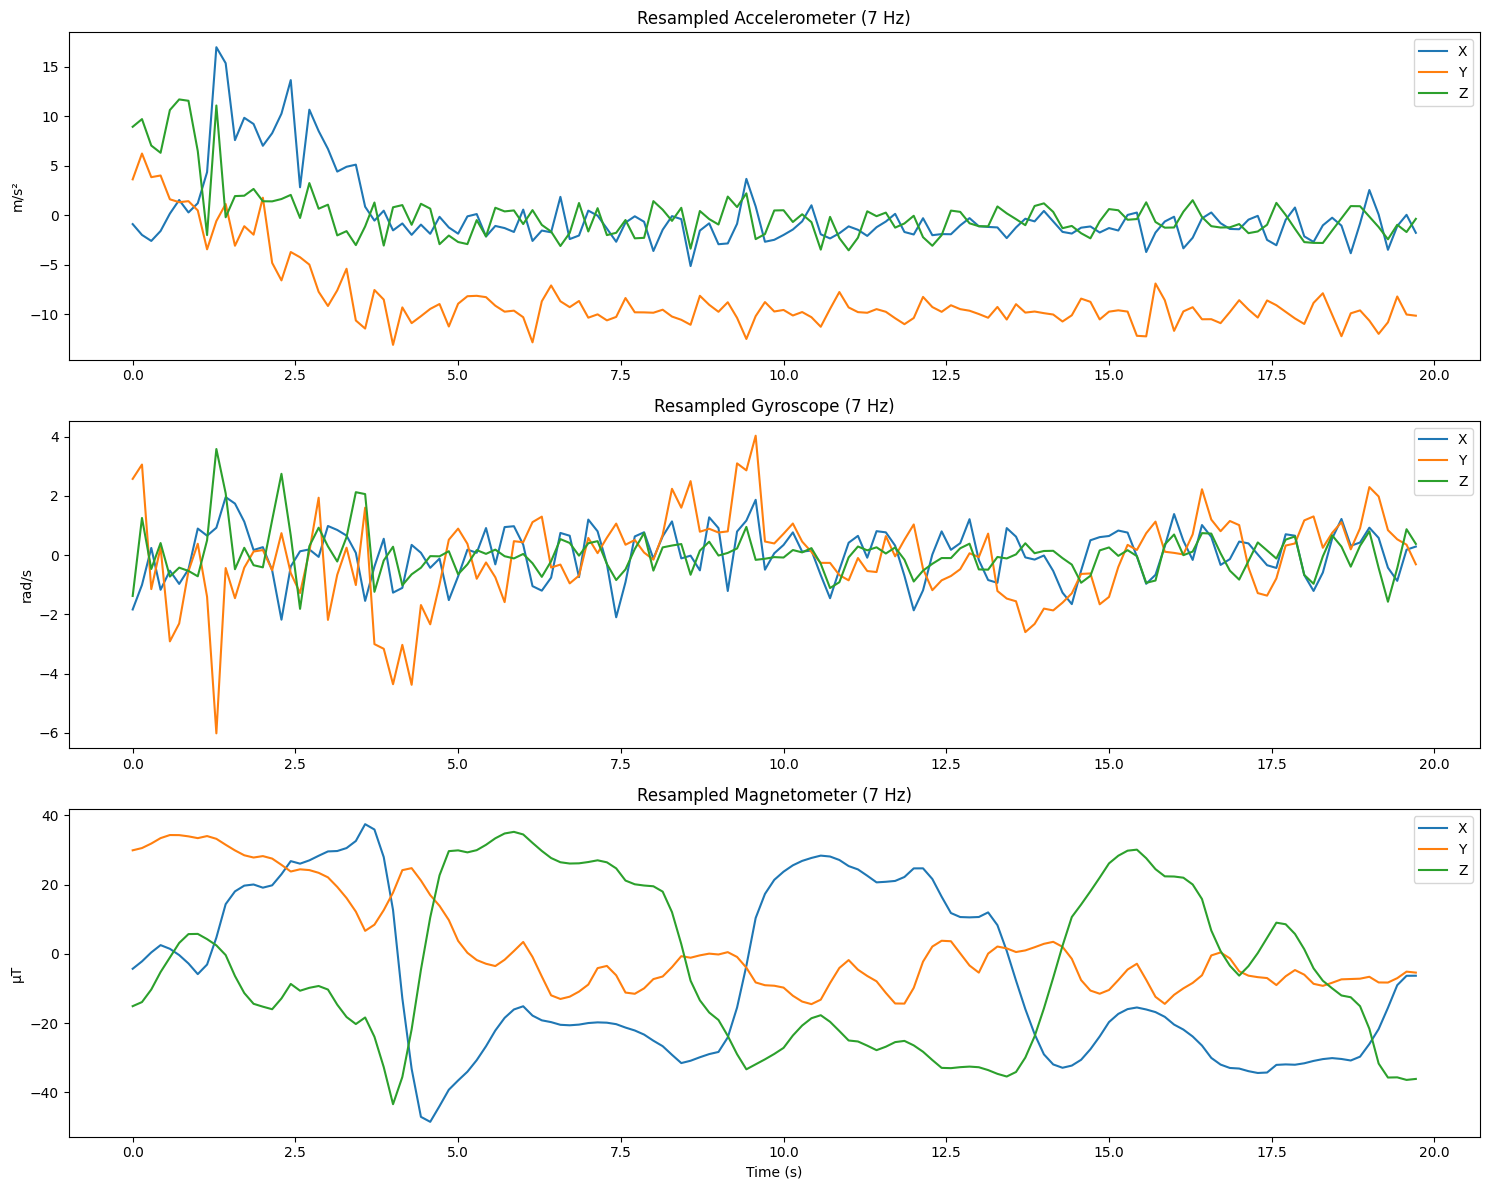

In [ ]:
# Plotting
plt.figure(figsize=(15, 12))

# Accelerometer
plt.subplot(3, 1, 1)
plt.plot(resampled_time, acc_x_r, label="X")
plt.plot(resampled_time, acc_y_r, label="Y")
plt.plot(resampled_time, acc_z_r, label="Z")
plt.title("Resampled Accelerometer (7 Hz)")
plt.ylabel("m/s²")
plt.legend()

# Gyroscope
plt.subplot(3, 1, 2)
plt.plot(resampled_time, gyro_x_r, label="X")
plt.plot(resampled_time, gyro_y_r, label="Y")
plt.plot(resampled_time, gyro_z_r, label="Z")
plt.title("Resampled Gyroscope (7 Hz)")
plt.ylabel("rad/s")
plt.legend()

# Magnetometer
plt.subplot(3, 1, 3)
plt.plot(resampled_time, mag_x_r, label="X")
plt.plot(resampled_time, mag_y_r, label="Y")
plt.plot(resampled_time, mag_z_r, label="Z")
plt.title("Resampled Magnetometer (7 Hz)")
plt.xlabel("Time (s)")
plt.ylabel("μT")
plt.legend()

plt.tight_layout()
plt.show()

# **Pre-processing**

**Loading signals, Resampling with a common frequency, fix the sample length**

In [3]:
import os
import numpy as np
import pandas as pd

# -----------------------------
# Configuration
# -----------------------------
data_dir = '/content/drive/MyDrive/Fed_auth'
target_freq = 7  # Hz (final common resampling frequency)
sampling_dis_ms = 10  # centroid grouping window in milliseconds

# Fixed length control: exactly 140 frames at 7 Hz => 20 seconds
fixed_length_frames = 140
fixed_length_s = fixed_length_frames / float(target_freq)  # 20.0 seconds

# -----------------------------
# Utilities
# -----------------------------
def safe_numeric(df, time_col="Time (ms)"):
    """Coerce numeric, drop rows without valid time, sort by time, and drop duplicate times."""
    df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
    df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
    for col in df.columns:
        if col != time_col:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=[time_col]).sort_values(time_col).drop_duplicates(subset=[time_col])
    return df.reset_index(drop=True)

def centroid_series(time_ms, values, window_ms=10):
    """
    Cluster consecutive rows where time difference <= window_ms and compute
    the centroid (mean) of the values within each cluster. Returns:
      - signal (list of float)
      - dt_list (list of float, milliseconds per cluster)
    """
    signal = []
    dt_list = []

    ref_time = None
    group_vals = []

    for t, v in zip(time_ms, values):
        if pd.isna(v):
            continue  # skip missing values

        if ref_time is None:
            # start first group
            ref_time = t
            group_vals = [v]
        elif (t - ref_time) <= window_ms:
            # still inside the window for current group
            group_vals.append(v)
        else:
            # close current group
            signal.append(float(np.mean(group_vals)))
            dt_list.append(float(t - ref_time))  # group duration
            # start new group
            ref_time = t
            group_vals = [v]

    # flush last group
    if group_vals:
        signal.append(float(np.mean(group_vals)))
        if len(dt_list) == 0:
            dt_list.append(float(window_ms))
        else:
            dt_list.append(float(dt_list[-1]))

    return signal, dt_list

def estimate_frequency(dt_list_ms):
    """Estimate sampling frequency from centroid group durations (Hz)."""
    if len(dt_list_ms) == 0:
        return None
    dt_ms = np.array(dt_list_ms, dtype=float)
    dt_ms = dt_ms[~np.isnan(dt_ms)]
    if dt_ms.size == 0:
        return None
    median_dt_ms = float(np.median(dt_ms))
    if median_dt_ms <= 0:
        return None
    return 1_000.0 / median_dt_ms

def build_time_axis(n_samples, freq_hz):
    """Synthetic time axis (seconds) of length n_samples with frequency freq_hz."""
    if (n_samples is None) or (n_samples < 2) or (freq_hz is None) or (freq_hz <= 0):
        return None
    return np.arange(n_samples, dtype=float) / float(freq_hz)

def resample_linear(original_time_s, signal, target_time_s):
    """
    Safe 1D resampling using numpy.interp (no SciPy).
    If insufficient points (<2), returns zeros of length target_time_s.
    """
    target_time_s = np.asarray(target_time_s, dtype=float)
    # If we don't have a valid source time/signal, just return zeros of the target length
    if (original_time_s is None) or (signal is None):
        return np.zeros(len(target_time_s), dtype=float)

    signal = np.asarray(signal, dtype=float)
    original_time_s = np.asarray(original_time_s, dtype=float)

    if (len(signal) < 2) or (len(original_time_s) < 2):
        return np.zeros(len(target_time_s), dtype=float)

    return np.interp(
        target_time_s,
        original_time_s,
        signal,
        left=float(signal[0]),
        right=float(signal[-1])
    )


def pad_or_truncate(matrix, desired_len):
    """
    Pad by repeating the last row or truncate by cutting from the beginning
    (keep the last `desired_len` rows). Operates along time dimension (axis=0).

    Parameters
    ----------
    matrix : np.ndarray
        2D array of shape (T, C), where T is time steps and C is channels.
    desired_len : int
        Target number of time steps.

    Returns
    -------
    np.ndarray
        Array of shape (desired_len, C).
    """

    if desired_len < 0:
        raise ValueError("desired_len must be non-negative")

    if matrix.ndim != 2:
        raise ValueError(f"`matrix` must be 2D (T, C); got shape {matrix.shape}")

    t, c = matrix.shape

    # Handle empty desired length explicitly
    if desired_len == 0:
        return np.zeros((0, c), dtype=matrix.dtype)

    if t == desired_len:
        return matrix

    if t > desired_len:
        # Truncate by removing from the beginning (keep the last desired_len)
        return matrix[-desired_len:, :]

    # t < desired_len: pad by repeating the last row
    pad_amount = desired_len - t
    if t == 0:
        # No last row to repeat — fall back to zeros
        last_row = np.zeros((1, c), dtype=matrix.dtype)
    else:
        last_row = matrix[-1:, :]  # shape (1, C)

    pad_block = np.repeat(last_row, repeats=pad_amount, axis=0)  # shape (pad_amount, C)
    return np.vstack([matrix, pad_block])


# -----------------------------
# Main processing
# -----------------------------
X_data = []          # list of (T, 9) but will be padded/truncated to (140, 9)
subject_ids = []     # subject folder names
activity_labels = [] # activity names from file name
lengths_before_fix = []  # track raw resampled lengths before final pad/cut
sensor_cols = [
    "ACCELEROMETER_X", "ACCELEROMETER_Y", "ACCELEROMETER_Z",
    "GYROSCOPE_X",     "GYROSCOPE_Y",     "GYROSCOPE_Z",
    "MAGNETIC_FIELD_X","MAGNETIC_FIELD_Y","MAGNETIC_FIELD_Z"
]
time_col = "Time (ms)"

for subject_id in os.listdir(data_dir):
    subject_path = os.path.join(data_dir, subject_id)
    if not os.path.isdir(subject_path):
        continue

    inertial_path = os.path.join(subject_path, 'inertial')
    if not os.path.exists(inertial_path):
        continue

    for iteration in os.listdir(inertial_path):
        iteration_path = os.path.join(inertial_path, iteration)
        if not os.path.isdir(iteration_path):
            continue

        for file_name in os.listdir(iteration_path):
            if not file_name.endswith('.csv'):
                continue

            file_path = os.path.join(iteration_path, file_name)
            try:
                df = pd.read_csv(file_path)
                # Ensure expected columns exist; if not, try to rename by position
                if len(df.columns) >= 10:
                    df.columns = [time_col] + sensor_cols
                else:
                    raise ValueError(f"Unexpected column count ({len(df.columns)}) in {file_path}")

                df = safe_numeric(df, time_col=time_col)

                # Centroid sampling per sensor axis
                signals = []
                freqs = []

                time_ms = df[time_col].to_numpy(dtype=float)

                for col in sensor_cols:
                    sig, dt_list = centroid_series(time_ms, df[col].to_numpy(dtype=float), window_ms=sampling_dis_ms)
                    signals.append(sig)
                    f = estimate_frequency(dt_list)
                    freqs.append(f)

                # Synthetic time axes (seconds). If any has <2 points or None, we let resampler return zeros.
                acc_time = build_time_axis(len(signals[0]), freqs[0])
                gyro_time = build_time_axis(len(signals[3]), freqs[3])
                mag_time = build_time_axis(len(signals[6]), freqs[6])

                # Determine common duration and clamp to fixed window
                # If all time axes are None, default to 0 duration (will be padded to zeros)
                end_times = []
                for t_axis in (acc_time, gyro_time, mag_time):
                    if t_axis is not None and len(t_axis) > 0:
                        end_times.append(float(t_axis[-1]))
                duration = float(min(end_times)) if end_times else 0.0

                duration_used = float(min(duration, fixed_length_s))
                # Build target time grid up to duration_used (may be 0 if no usable data)
                resampled_time = np.arange(0.0, duration_used, 1.0 / float(target_freq), dtype=float)

                # Resample all 9 axes onto the target grid
                acc_x_r = resample_linear(acc_time, signals[0] if len(signals) > 0 else None, resampled_time)
                acc_y_r = resample_linear(acc_time, signals[1] if len(signals) > 1 else None, resampled_time)
                acc_z_r = resample_linear(acc_time, signals[2] if len(signals) > 2 else None, resampled_time)

                gyro_x_r = resample_linear(gyro_time, signals[3] if len(signals) > 3 else None, resampled_time)
                gyro_y_r = resample_linear(gyro_time, signals[4] if len(signals) > 4 else None, resampled_time)
                gyro_z_r = resample_linear(gyro_time, signals[5] if len(signals) > 5 else None, resampled_time)

                mag_x_r = resample_linear(mag_time, signals[6] if len(signals) > 6 else None, resampled_time)
                mag_y_r = resample_linear(mag_time, signals[7] if len(signals) > 7 else None, resampled_time)
                mag_z_r = resample_linear(mag_time, signals[8] if len(signals) > 8 else None, resampled_time)

                # Stack into (T, 9)
                x_matrix = np.stack([
                    acc_x_r, acc_y_r, acc_z_r,
                    gyro_x_r, gyro_y_r, gyro_z_r,
                    mag_x_r, mag_y_r, mag_z_r
                ], axis=1)  # shape: (T, 9)

                # Record raw resampled length
                lengths_before_fix.append(x_matrix.shape[0])

                # Enforce exactly 140 frames (pad smaller, cut larger)
                x_matrix = pad_or_truncate(x_matrix, fixed_length_frames)  # now (140, 9)

                X_data.append(x_matrix)
                subject_ids.append(subject_id)
                activity_labels.append(file_name.replace('.csv', ''))

            except Exception as e:
                print(f"Error processing {file_path}: {e}")

# -----------------------------
# Final outputs
# -----------------------------
# X: (N, 140, 9)
if len(X_data) == 0:
    X = np.zeros((0, fixed_length_frames, 9), dtype=float)
else:
    X = np.stack(X_data, axis=0)

subjects = np.array(subject_ids, dtype=object)
activities = np.array(activity_labels, dtype=object)

print(f"Samples processed: {len(X_data)}")
print(f"Target frequency: {target_freq} Hz")
print(f"Fixed frames per sample: {fixed_length_frames} (i.e., {fixed_length_s:.1f} s)")
if len(lengths_before_fix) > 0:
    print(f"Raw resampled lengths (before pad/cut): mean={int(np.mean(lengths_before_fix))}, "
          f"min={min(lengths_before_fix)}, max={max(lengths_before_fix)}")
print(f"Final X shape: {X.shape}  # (N, 140, 9)")

Samples processed: 396
Target frequency: 7 Hz
Fixed frames per sample: 140 (i.e., 20.0 s)
Raw resampled lengths (before pad/cut): mean=137, min=121, max=140
Final X shape: (396, 140, 9)  # (N, 140, 9)


**Filtering and noise reduction**

In [4]:
import numpy as np
from scipy.signal import butter, sosfiltfilt

def _butter_lpf_sos(cutoff_hz: float, fs_hz: float, order: int = 2):
    """
    Create an SOS low-pass Butterworth filter.
    """
    if cutoff_hz >= fs_hz / 2:
        raise ValueError(f"cutoff_hz={cutoff_hz} must be < Nyquist={fs_hz/2}.")
    sos = butter(order, cutoff_hz, btype='low', fs=fs_hz, output='sos')
    return sos

def _apply_sosfiltfilt(x: np.ndarray, sos) -> np.ndarray:
    """
    Zero-phase filter along time axis (axis=1).
    Expects x with shape (N, T, C) or (T, C) or (N, T).
    """
    return sosfiltfilt(sos, x, axis=1)

def process_imu_with_gravity_body(
    X: np.ndarray,
    fs: float = 7.0,
    order: int = 2,
    fc_noise: float = 3.0,
    fc_gravity: float = 0.3,
    apply_noise_reduction: bool = True,
    apply_acc_decomposition: bool = True,
    channel_order: str = 'acc-gyro-mag'
) -> np.ndarray:
    """
    Process IMU tensor X of shape (N, T, 9) with channels:
      acc(x,y,z), gyro(x,y,z), mag(x,y,z).

    Steps (configurable):
      - Noise reduction (LPF at fc_noise) on all channels [optional].
      - Accelerometer gravity/body decomposition (LPF at fc_gravity) [optional].

    Output:
      - If apply_acc_decomposition=True:
            concat([acc_body(3), acc_gravity(3), gyro_out(3), mag_out(3)]) -> (N, T, 12)
      - If apply_acc_decomposition=False:
            concat([acc_base(3), gyro_out(3), mag_out(3)]) -> (N, T, 9)
        where acc_base = acc_denoised if apply_noise_reduction else raw acc.

    Args:
        X: np.ndarray of shape (N, T, 9)
        fs: sampling rate in Hz (e.g., 7.0)
        order: Butterworth filter order (e.g., 2)
        fc_noise: cutoff for noise LPF (e.g., 3.0 Hz)
        fc_gravity: cutoff for gravity LPF (e.g., 0.3 Hz)
        apply_noise_reduction: enable/disable noise LPF
        apply_acc_decomposition: enable/disable acc gravity/body split

    Returns:
        np.ndarray with shape (N, T, 12) or (N, T, 9) depending on flags.
    """
    if X.ndim != 3 or X.shape[-1] != 9:
        raise ValueError("X must have shape (N, T, 9).")

    # Split channels (adjust if your ordering differs)
    acc  = X[..., 0:3]
    gyro = X[..., 3:6]
    mag  = X[..., 6:9]

    # --- Optional noise reduction on all channels ---
    if apply_noise_reduction:
        if fc_noise >= fs / 2:
            raise ValueError(f"fc_noise={fc_noise} must be < Nyquist={fs/2}.")
        sos_noise = _butter_lpf_sos(fc_noise, fs, order)
        acc_base      = _apply_sosfiltfilt(acc,  sos_noise)
        gyro_filtered = _apply_sosfiltfilt(gyro, sos_noise)
        mag_filtered  = _apply_sosfiltfilt(mag,  sos_noise)
    else:
        acc_base      = acc
        gyro_filtered = gyro
        mag_filtered  = mag

    # --- Optional gravity/body decomposition of accelerometer ---
    if apply_acc_decomposition:
        if fc_gravity >= fs / 2:
            raise ValueError(f"fc_gravity={fc_gravity} must be < Nyquist={fs/2}.")
        sos_grav    = _butter_lpf_sos(fc_gravity, fs, order)
        acc_gravity = _apply_sosfiltfilt(acc_base, sos_grav)
        acc_body    = acc_base - acc_gravity
        X_out = np.concatenate([acc_body, acc_gravity, gyro_filtered, mag_filtered], axis=-1)
        # Sanity check
        N, T, _ = X.shape
        assert X_out.shape == (N, T, 12), f"Unexpected output shape {X_out.shape}"
    else:
        # No decomposition: keep 9 channels (acc_base + gyro + mag)
        X_out = np.concatenate([acc_base, gyro_filtered, mag_filtered], axis=-1)
        N, T, _ = X.shape
        assert X_out.shape == (N, T, 9), f"Unexpected output shape {X_out.shape}"

    return X_out



In [5]:
# Case A: Both noise reduction and decomposition -> (N, T, 12)
X_processed = process_imu_with_gravity_body(
    X, fs=7, order=4, fc_noise=3, fc_gravity=0.3,
    apply_noise_reduction=False, apply_acc_decomposition=True
)
print("shape:", X_processed.shape)

shape: (396, 140, 12)


**Segmentation**

In [6]:
import numpy as np

def segment_sliding_windows(X, subjects=None, activities=None, window_len=16, overlap=0.5):
    """
    Segment inertial data using a sliding window with specified overlap.

    Parameters
    ----------
    X : np.ndarray
        Either (T, C) for a single sample or (N, T, C) for multiple samples.
    subjects : array-like or None
        If X is (N, T, C), subjects should be length N.
        If X is (T, C), subjects can be a single value or None.
    activities : array-like or None
        Same rules as `subjects`.
    window_len : int
        Window length in samples (default 16).
    overlap : float
        Fractional overlap (0.0–0.99). 0.5 => 50% overlap; step = window_len * (1 - overlap).

    Returns
    -------
    Xw : np.ndarray
        (M, window_len, C)
    subjects_w : np.ndarray or None
        (M,)
    activities_w : np.ndarray or None
        (M,)
    """
    # Normalize to (N, T, C)
    single_sample = False
    if X.ndim == 2:
        X = X[None, ...]  # (1, T, C)
        single_sample = True
    elif X.ndim != 3:
        raise ValueError(f"`X` must be 2D or 3D; got shape {X.shape}")

    N, T, C = X.shape

    # Step for given overlap
    step = int(round(window_len * (1.0 - overlap)))
    step = max(1, step)

    Xw_list, subj_list, act_list = [], [], []

    # Helper to get label for sample i
    def label_for(i, label):
        if label is None:
            return None
        if single_sample and not hasattr(label, "__len__"):
            return label
        return label[i]

    for i in range(N):
        Xi = X[i]  # (T, C)
        if Xi.shape[0] < window_len:
            continue  # skip samples too short

        for start in range(0, T - window_len + 1, step):
            window = Xi[start:start + window_len, :]  # (16, C)
            Xw_list.append(window)
            if subjects is not None:
                subj_list.append(label_for(i, subjects))
            if activities is not None:
                act_list.append(label_for(i, activities))

    # Stack outputs
    Xw = np.stack(Xw_list, axis=0) if len(Xw_list) > 0 else np.zeros((0, window_len, C), dtype=X.dtype)
    subjects_w = np.array(subj_list, dtype=object) if subjects is not None else None
    activities_w = np.array(act_list, dtype=object) if activities is not None else None

    return Xw, subjects_w, activities_w

In [7]:
# Given:
# X shape: (396, 140, 9)
# subjects shape: (396,)
# activities shape: (396,)

Xw, subjects_w, activities_w = segment_sliding_windows(
    X_processed, subjects=subjects, activities=activities, window_len=16, overlap=0.5
)

print("Windowed X shape:", Xw.shape)                 # -> (6336, 16, 9)
print("Windowed subjects shape:", subjects_w.shape)  # -> (6336,)
print("Windowed activities shape:", activities_w.shape)  # -> (6336,)


Windowed X shape: (6336, 16, 12)
Windowed subjects shape: (6336,)
Windowed activities shape: (6336,)


In [48]:
# Save dataset
np.savez("/content/drive/MyDrive/Fed_auth/fed_auth_dataset.npz", X=Xw, subjects=subjects_w, activities=activities_w)


**Down Sampling**

In [15]:
from scipy.signal import resample_poly
import numpy as np

def downsample_with_filter(X, fs=7.0, target_fs_list=(3.5, 1.75, 0.875, 0.4375)):
    """
    Downsample (N, 16, 12) safely using polyphase filtering.
    Returns dict with versions for each target frequency.
    """
    N, T, C = X.shape
    out = {'original': {'fs': fs, 'X': X, 'length': T}}
    for f_target in target_fs_list:
        factor = int(round(fs / f_target))
        X_ds = resample_poly(X, up=1, down=factor, axis=1)
        out[f'fs_{f_target}'] = {'fs': f_target, 'X': X_ds, 'length': X_ds.shape[1]}
    return out


versions = downsample_with_filter(Xw)
Xd = versions['fs_1.75']['X']

print("Windowed X shape:", Xd.shape)                 # -> (6336, 16, 9)
print("Windowed subjects shape:", subjects_w.shape)  # -> (6336,)
print("Windowed activities shape:", activities_w.shape)  # -> (6336,)

Windowed X shape: (6336, 4, 12)
Windowed subjects shape: (6336,)
Windowed activities shape: (6336,)


# **Classification**

In [9]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# ---------------------------
# Reproducibility
# ---------------------------
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ---------------------------
# Simple 1D CNN for windowed IMU
# ---------------------------
class CNN1D(nn.Module):
    """
    Expects input tensors of shape (B, T=16, C=9).
    Internally permutes to (B, C, T) for Conv1d.
    """
    def __init__(self, input_dim=9, n_classes=6):  # set n_classes dynamically later
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=5, padding=2)
        self.bn1   = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.bn2   = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm1d(256)

        self.dropout = nn.Dropout(0.5)
        self.pool    = nn.AdaptiveMaxPool1d(1)  # global pooling
        self.fc      = nn.Linear(256, n_classes)

    def forward(self, x):
        # x: (B, T, C) -> (B, C, T)
        x = x.permute(0, 2, 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        x = self.pool(x).squeeze(-1)  # (B, 256)
        logits = self.fc(x)           # (B, n_classes)
        return logits

# ---------------------------
# Build DataLoaders
# ---------------------------
def make_dataloaders(Xw, activities_w, test_size=0.2, batch_size=128, seed=42):
    """
    Xw: (M, 16, 9) windowed data
    activities_w: (M,) labels per window (strings or ints)
    Returns: train_loader, test_loader, label_encoder, n_classes
    """
    # Label encode activities
    le = LabelEncoder()
    y = le.fit_transform(activities_w)
    n_classes = len(le.classes_)
    print("Classes found:", le.classes_)

    # Train/test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        Xw, y, test_size=test_size, random_state=seed, stratify=y
    )

    # Convert to torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # (N_train, 16, 9)
    X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32)  # (N_test,  16, 9)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_test_tensor  = torch.tensor(y_test,  dtype=torch.long)

    # Datasets & loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, drop_last=False)

    return train_loader, test_loader, le, n_classes

# ---------------------------
# Train / Evaluate
# ---------------------------
def train_cnn(
    Xw, activities_w,
    batch_size=128, epochs=50, lr=5e-4, weight_decay=1e-4,
    label_smoothing=0.1, seed=42, early_stop_patience=10
):
    set_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Dataloaders & labels
    train_loader, test_loader, le, n_classes = make_dataloaders(
        Xw, activities_w, test_size=0.2, batch_size=batch_size, seed=seed
    )

    # Model
    model = CNN1D(input_dim=Xw.shape[-1], n_classes=n_classes).to(device)

    # Loss, optimizer, scheduler
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    best_val_loss = float("inf")
    patience_counter = 0
    best_state = None

    for epoch in range(1, epochs + 1):
        # ---- Train ----
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        train_loss = total_loss / max(1, len(train_loader))
        train_acc = correct / max(1, total)

        # ---- Validation ----
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, dim=1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

        val_loss = val_loss / max(1, len(test_loader))
        val_acc = correct / max(1, total)
        scheduler.step(val_loss)

        print(f"Epoch {epoch}/{epochs} "
              f"Train Loss: {round(train_loss,4):.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {round(val_loss,4):.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered!")
                break

    # Restore best state
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, le


**Train a 1-D CNN model for activity recognition**

In [13]:
'''

# Path to your saved dataset
file_path = "/content/drive/MyDrive/Fed_auth/fed_auth_dataset.npz"

# Load the .npz file
data = np.load(file_path, allow_pickle=True)

# Extract arrays
X = data["X"]            # shape: (396*k, 16, 9)
subjects = data["subjects"]  # shape: (396*k,)
activities = data["activities"]  # shape: (396*k,)

# Check shapes
print("X shape:", X.shape)
print("Subjects shape:", subjects.shape)
print("Activities shape:", activities.shape)
'''


model, label_encoder = train_cnn(Xd, activities_w,
                                  batch_size=128, epochs=200, lr=5e-4,
                                  weight_decay=1e-4, label_smoothing=0.1,
                                  seed=42, early_stop_patience=30)

Classes found: ['normal_walking' 'sitting' 'slow_walking' 'stairs_climbing']
Epoch 1/200 Train Loss: 1.2915, Train Acc: 0.4449 | Val Loss: 1.2533, Val Acc: 0.5615
Epoch 2/200 Train Loss: 1.1198, Train Acc: 0.5854 | Val Loss: 1.0889, Val Acc: 0.5994
Epoch 3/200 Train Loss: 1.0315, Train Acc: 0.6296 | Val Loss: 1.0210, Val Acc: 0.6569
Epoch 4/200 Train Loss: 0.9954, Train Acc: 0.6474 | Val Loss: 0.9960, Val Acc: 0.6349
Epoch 5/200 Train Loss: 0.9778, Train Acc: 0.6577 | Val Loss: 0.9801, Val Acc: 0.6412
Epoch 6/200 Train Loss: 0.9446, Train Acc: 0.6728 | Val Loss: 0.9553, Val Acc: 0.6743
Epoch 7/200 Train Loss: 0.9248, Train Acc: 0.6796 | Val Loss: 0.9426, Val Acc: 0.6648
Epoch 8/200 Train Loss: 0.9226, Train Acc: 0.6821 | Val Loss: 0.9239, Val Acc: 0.6806
Epoch 9/200 Train Loss: 0.9037, Train Acc: 0.7032 | Val Loss: 0.9119, Val Acc: 0.7011
Epoch 10/200 Train Loss: 0.8964, Train Acc: 0.7028 | Val Loss: 0.8996, Val Acc: 0.7035
Epoch 11/200 Train Loss: 0.8868, Train Acc: 0.7024 | Val Loss:

KeyboardInterrupt: 

**Train a 1-D CNN model for subject identification**

In [ ]:
model, label_encoder = train_cnn(Xd, subjects_w,
                                  batch_size=128, epochs=200, lr=5e-4,
                                  weight_decay=1e-4, label_smoothing=0.1,
                                  seed=42, early_stop_patience=30)

Classes found: ['0840a551-9721-4434-964e-7a40a110a0bb'
 '0991877e-9ec8-4f79-b13a-84e3d9103011'
 '12c70db2-fbdf-4316-ac6a-482cd23952b8'
 '14ec96d0-41ef-4cdc-830f-e51ccc199189'
 '1f04d012-9569-4d97-81e7-2897b19a8605'
 '20b976ec-f3d3-467c-afff-8fc648b62a0d'
 '32f9d687-edcf-429e-8fcd-5a6637864cbe'
 '396f315d-d810-499f-9c61-cd3b447d88fc'
 '48f54667-8eff-4684-a5c7-034ec4d15fcc'
 '4b2e1202-1107-4b8d-a2e3-abd0afe94562'
 '50ec9984-a45f-4d1d-8689-33a6bc49c43f'
 '60097505-c938-47c4-aec9-2ac9e915c3f1'
 '6c9462a3-9880-4ffa-b454-66650f61b602'
 '7ca68cde-2ae1-4c0e-bdd2-7d7901f6a2a2'
 '7cbef553-8ff3-40a8-9aaa-64ccfc13b673'
 '856d7434-4ddb-4b06-b13a-a93542c8812b'
 '872a3aa4-2af4-4b65-b3f0-1bbaaf36d2e4'
 '8d185d8d-6216-4684-a161-bd564a3645e5'
 '95d013fa-eb14-42ed-8b6a-d01f51516f8f'
 '98bda299-9733-420c-a7dc-7449f5f2f2c3'
 '9cb4ba22-8ec3-4e98-96a6-e7a4a4bed3a1'
 'a16a43bc-d800-497e-baf2-83f9ac6ec97b'
 'aa1b7628-6e73-4030-9319-ff3b03cba2e2'
 'aa7f4402-ff80-4a0d-b70b-40b6f9e4c000'
 'ab1ccb1b-fd13-4f6b-aa77